# Project 4
## Goal(s):

Predict if the page is being flipped using a single image.

## Success Metrics:

Evaluate model performance based on F1 score, the higher the better.

## Bonus(es):

Predict if a given sequence of images contains an action of flipping.


In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# # data visualization
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# # Algorithms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


# #Cross validation
# from sklearn.model_selection import KFold, cross_val_score

# #Other
# from sklearn import metrics
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

# #class imbalance
# from sklearn.metrics import f1_score
# from sklearn.utils import resample

import os


In [2]:
# Directory with our training flip pictures
train_flip_dir = os.path.join('/Users/natalie/Dropbox/Apziva/images/training/flip')

# Directory with our training not flip pictures
train_notflip_dir = os.path.join('/Users/natalie/Dropbox/Apziva/images/training/notflip')

# Directory with our test flip pictures
test_flip_dir = os.path.join('/Users/natalie/Dropbox/Apziva/images/testing/flip')

# Directory with our test not flip pictures
test_notflip_dir = os.path.join('/Users/natalie/Dropbox/Apziva/images/testing/notflip')

In [4]:
train_flip_names = os.listdir(train_flip_dir)
print(train_flip_names[:10])

train_notflip_names = os.listdir(train_notflip_dir)
print(train_notflip_names[:10])

test_flip_names = os.listdir(test_flip_dir)
print(test_flip_names[:10])

test_notflip_names = os.listdir(test_notflip_dir)
print(test_notflip_names[:10])

['0005_000000020.jpg', '0038_000000009.jpg', '0011_000000019.jpg', '0062_000000023.jpg', '0038_000000021.jpg', '0038_000000035.jpg', '0011_000000025.jpg', '0010_000000017.jpg', '0039_000000013.jpg', '0004_000000012.jpg']
['0005_000000020.jpg', '0011_000000019.jpg', '0005_000000008.jpg', '0038_000000021.jpg', '0011_000000025.jpg', '0039_000000007.jpg', '0010_000000017.jpg', '0039_000000013.jpg', '0010_000000003.jpg', '0004_000000006.jpg']
['0005_000000008.jpg', '0063_000000011.jpg', '0004_000000006.jpg', '0012_000000008.jpg', '0061_000000026.jpg', '0006_000000025.jpg', '0028_000000019.jpg', '0014_000000016.jpg', '0059_000000028.jpg', '0058_000000027.jpg']
['0038_000000009.jpg', '0004_000000012.jpg', '0006_000000025.jpg', '0006_000000019.jpg', '0015_000000018.jpg', '0001_000000009.jpg', '0029_000000017.jpg', '0029_000000003.jpg', '0016_000000020.jpg', '0028_000000024.jpg']


In [5]:
print('total training flip images:', len(os.listdir(train_flip_dir)))
print('total training not flip images:', len(os.listdir(train_notflip_dir)))
print('total testing flip images:', len(os.listdir(test_flip_dir)))
print('total testing not flip images:', len(os.listdir(test_notflip_dir)))

total training flip images: 1162
total training not flip images: 1230
total testing flip images: 290
total testing not flip images: 307


In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

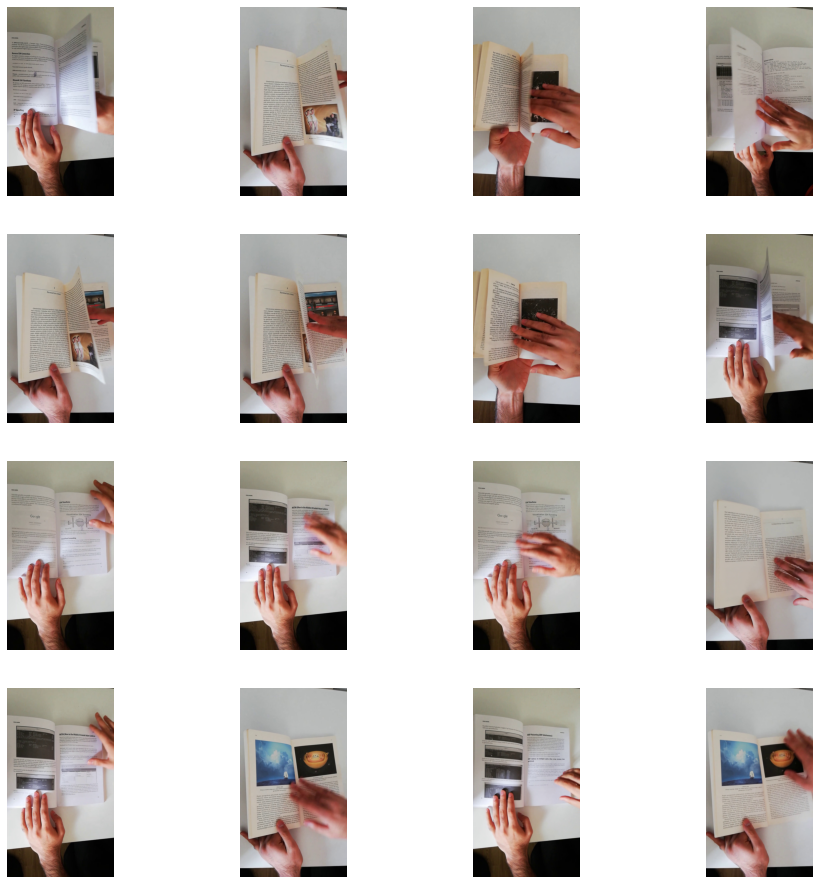

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_flip_pic = [os.path.join(train_flip_dir, fname) 
                for fname in train_flip_names[pic_index-8:pic_index]]
next_notflip_pic = [os.path.join(train_notflip_dir, fname) 
                for fname in train_notflip_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_flip_pic + next_notflip_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/Users/natalie/Dropbox/Apziva/images/training/',  # This is the source directory for training images
        classes = ['flip', 'notflip'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=299,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = test_datagen.flow_from_directory(
        '/Users/natalie/Dropbox/Apziva/images/testing/',  # This is the source directory for training images
        classes = ['flip', 'notflip'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=74,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [14]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (200,200,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 120000)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               15360128  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15360257 (58.59 MB)
Trainable params: 15360257 (58.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Q: batch vs epoch > how to pick what to change?

In [17]:
history = model.fit(train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 71s 9s/step - loss: 39.1672 - accuracy: 0.5021 - val_loss: 9.3916 - val_accuracy: 0.4899
Epoch 2/15
8/8 [==============================] - 62s 8s/step - loss: 5.4324 - accuracy: 0.5176 - val_loss: 3.6341 - val_accuracy: 0.4899
Epoch 3/15
8/8 [==============================] - 63s 8s/step - loss: 3.0858 - accuracy: 0.5025 - val_loss: 0.7245 - val_accuracy: 0.5135
Epoch 4/15
8/8 [==============================] - 62s 8s/step - loss: 1.5525 - accuracy: 0.5176 - val_loss: 0.7968 - val_accuracy: 0.5118
Epoch 5/15
8/8 [==============================] - 65s 8s/step - loss: 0.9905 - accuracy: 0.5468 - val_loss: 1.0418 - val_accuracy: 0.4899
Epoch 6/15
8/8 [==============================] - 67s 9s/step - loss: 0.8435 - accuracy: 0.5665 - val_loss: 0.8060 - val_accuracy: 0.4899
Epoch 7/15
8/8 [==============================] - 68s 9s/step - loss: 0.6624 - accuracy: 0.6099 - val_loss: 0.5786 - val_accuracy: 0.6791
Epoch 8/15
8/8 [=================

In [18]:
model.evaluate(validation_generator)

9/9 [==============================] - 12s 1s/step - loss: 0.4612 - accuracy: 0.8074


[0.4612249433994293, 0.8073701858520508]

In [19]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

9/9 [==============================] - 12s 1s/step


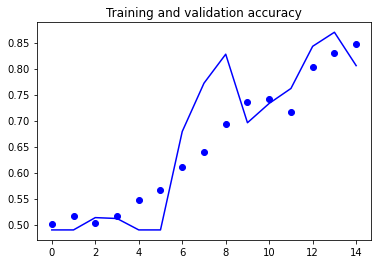

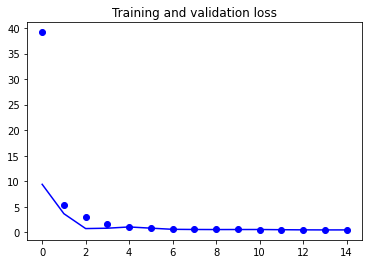

<Figure size 432x288 with 0 Axes>

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.figure()

plt.show()

In [23]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [24]:
roc_auc = auc(fpr, tpr)
#ROC curve is a probability curve plotting the true-positive rate (TPR) against the false-positive rate (FPR). 

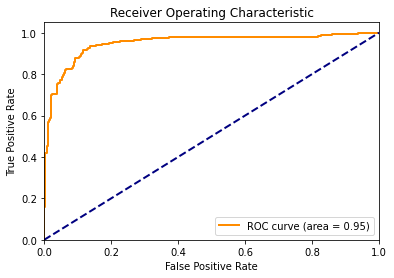

In [25]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()